<a href="https://colab.research.google.com/github/gwillig/maschine-learning-notebooks-for-interns/blob/master/explainable_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable AI


This notebook show how 4 methods how to explain AI models 

### Sections:
- 1. Misc: 
  - Installs all need libs
  - Functions for data processing 

- 2. EDA (Data exploratory data analysis)
- 3. Training of interpretable models
- 4. Use LIME for interpretation
- 5. Use SHAP for interpretation
- 6. Use Counterfactuals


 Source: https://github.com/deepfindr/xai-series/blob/master/utils.py

In [1]:
# Install need libs

!pip install interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 35.4 MB/s 
     |████████████████████████████████| 9.9 MB 53.8 MB/s 
     |████████████████████████████████| 3.6 MB 59.1 MB/s 
     |████████████████████████████████| 6.5 MB 62.7 MB/s 
     |████████████████████████████████| 758 kB 63.2 MB/s 
     |████████████████████████████████| 575 kB 61.9 MB/s 
     |████████████████████████████████| 275 kB 72.2 MB/s 
     |████████████████████████████████| 280 kB 5.7 MB/s 
     |████████████████████████████████| 261 kB 33.0 MB/s 
     |████████████████████████████████| 1.6 MB 42.7 MB/s 
     |████████████████████████████████| 132 kB 68.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d2bac6fa3c78c84482fb074599c91e61739d7b120b55f558c7c1812a1b73637f
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successf

In [2]:
## Utils
import pandas as pd 
# Makes sure we see all columns
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

class DataLoader():
    def __init__(self):
        self.data = None

    def load_dataset(self, path="https://raw.githubusercontent.com/deepfindr/xai-series/master/data/healthcare-dataset-stroke-data.csv"):
        self.data = pd.read_csv(path)

    def preprocess_data(self):
        # One-hot encode all categorical columns
        categorical_cols = ["gender",
                            "ever_married",
                            "work_type",
                            "Residence_type",
                            "smoking_status"]
        encoded = pd.get_dummies(self.data[categorical_cols], 
                                prefix=categorical_cols)

        # Update data with new columns
        self.data = pd.concat([encoded, self.data], axis=1)
        self.data.drop(categorical_cols, axis=1, inplace=True)

        # Impute missing values of BMI
        self.data.bmi = self.data.bmi.fillna(0)
        
        # Drop id as it is not relevant
        self.data.drop(["id"], axis=1, inplace=True)

        # Standardization 
        # Usually we would standardize here and convert it back later
        # But for simplification we will not standardize / normalize the features

    def get_data_split(self):
        X = self.data.iloc[:,:-1]
        y = self.data.iloc[:,-1]
        return train_test_split(X, y, test_size=0.20, random_state=2021)
    
    def oversample(self, X_train, y_train):
        oversample = RandomOverSampler(sampling_strategy='minority')
        # Convert to numpy and oversample
        x_np = X_train.to_numpy()
        y_np = y_train.to_numpy()
        x_np, y_np = oversample.fit_resample(x_np, y_np)
        # Convert back to pandas
        x_over = pd.DataFrame(x_np, columns=X_train.columns)
        y_over = pd.Series(y_np, name=y_train.name)
        return x_over, y_over

# 1. Data_exploration

(5110, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
col:  id


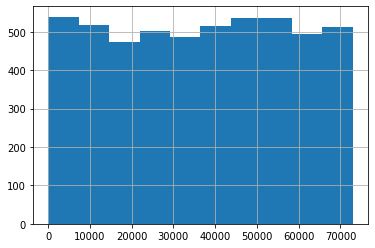

col:  gender


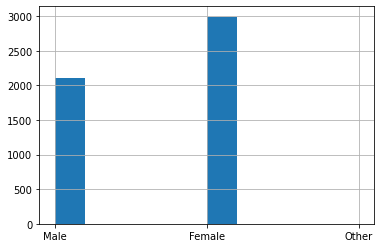

col:  age


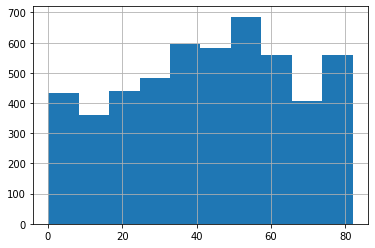

col:  hypertension


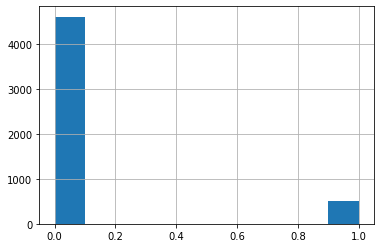

col:  heart_disease


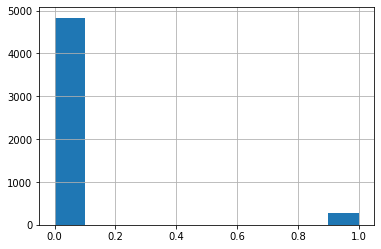

col:  ever_married


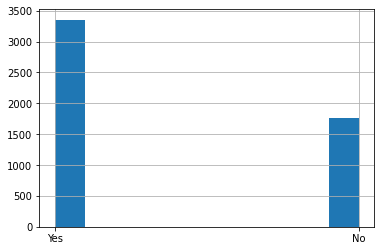

col:  work_type


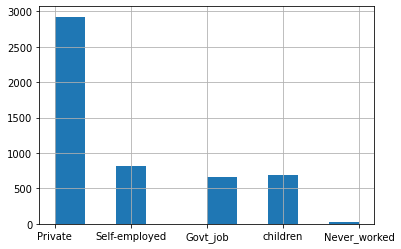

col:  Residence_type


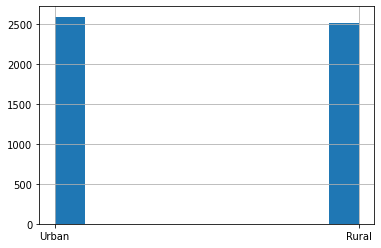

col:  avg_glucose_level


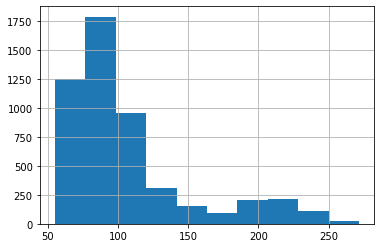

col:  bmi


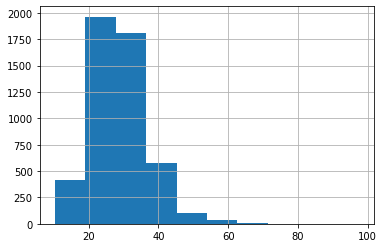

col:  smoking_status


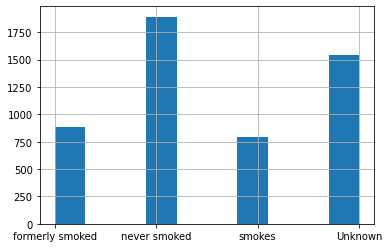

col:  stroke


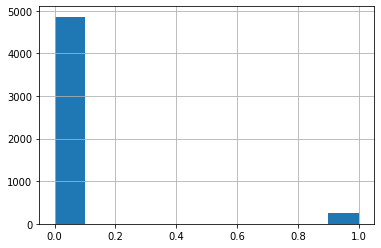

,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,67.0,0,1,228.69,36.6,1
1,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,61.0,0,0,202.21,0.0,1
2,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,80.0,0,1,105.92,32.5,1
3,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,49.0,0,0,171.23,34.4,1
4,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,79.0,1,0,174.12,24.0,1


In [3]:

### %% Imports
import matplotlib.pyplot as plt

# %% Load data
data_loader = DataLoader()
data_loader.load_dataset()
data = data_loader.data

# %% Show head
print(data.shape)
data.head()

# %% Show general statistics
data.info()

# %% Show histogram for all columns
columns = data.columns
for col in columns:
    print("col: ", col)
    data[col].hist()
    plt.show()

# %% Show preprocessed dataframe
data_loader.preprocess_data()
data_loader.data.head()



# 2. Interpretable_models

In [4]:
# %% Imports
from interpret.glassbox import (LogisticRegression,
                                ClassificationTree, 
                                ExplainableBoostingClassifier)
from interpret import show
from sklearn.metrics import f1_score, accuracy_score

# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()

# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
print(X_train.shape)
print(X_test.shape)
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print("After oversampling:", X_train.shape)

# %% Fit logistic regression model
lr = LogisticRegression(random_state=2021, feature_names=X_train.columns, penalty='l1', solver='liblinear')
lr.fit(X_train, y_train)
print("Training finished.")

# %% Evaluate logistic regression model
y_pred = lr.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain local prediction
lr_local = lr.explain_local(X_test[:100], y_test[:100], name='Logistic Regression')
show(lr_local)

# %% Explain global logistic regression model
lr_global = lr.explain_global(name='Logistic Regression')
show(lr_global)

# %% Fit decision tree model
tree = ClassificationTree()
tree.fit(X_train, y_train)
print("Training finished.")
y_pred = tree.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain local prediction
tree_local = tree.explain_local(X_test[:100], y_test[:100], name='Tree')
show(tree_local)

# %% Fit Explainable Boosting Machine
ebm = ExplainableBoostingClassifier(random_state=2021)
ebm.fit(X_train, y_train) 
print("Training finished.")
y_pred = ebm.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Explain locally
ebm_local = ebm.explain_local(X_test[:100], y_test[:100], name='EBM')
show(ebm_local)

# %% Explain globally
ebm_global = ebm.explain_global(name='EBM')
show(ebm_global)
# %%

(4088, 21)
(1022, 21)
After oversampling: (7778, 21)
Training finished.
F1 Score 0.5176317415875424
Accuracy 0.7407045009784736


Training finished.
F1 Score 0.5145303479811683
Accuracy 0.7250489236790607


Training finished.
F1 Score 0.5619782349433512
Accuracy 0.8649706457925636


# Use Lime for explaination

In [ ]:
# %% Imports
from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
from interpret.blackbox import LimeTabular
from interpret import show

# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

# %% Fit blackbox model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Apply lime
# Initilize Lime for Tabular data
lime = LimeTabular(predict_fn=rf.predict_proba, 
                   data=X_train, 
                   random_state=1)
# Get local explanations
lime_local = lime.explain_local(X_test[-20:], 
                                y_test[-20:], 
                                name='LIME')

show(lime_local)

# %%

 Use Shape

In [ ]:
# %% Imports
from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score
import shap

# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

# %% Fit blackbox model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")

# %% Create SHAP explainer
explainer = shap.TreeExplainer(rf)
# Calculate shapley values for test data
start_index = 1
end_index = 2
shap_values = explainer.shap_values(X_test[start_index:end_index])
X_test[start_index:end_index]

# %% Investigating the values (classification problem)
# class 0 = contribution to class 1
# class 1 = contribution to class 2
print(shap_values[0].shape)
shap_values

# %% >> Visualize local predictions
shap.initjs()
# Force plot
prediction = rf.predict(X_test[start_index:end_index])[0]
print(f"The RF predicted: {prediction}")
shap.force_plot(explainer.expected_value[1],
                shap_values[1],
                X_test[start_index:end_index]) # for values

# %% >> Visualize global features
# Feature summary
shap.summary_plot(shap_values, X_test)

# Use Counterfactuals

In [ ]:
# %% Imports
from utils import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score

# %% Load and preprocess data
data_loader = DataLoader()
data_loader.load_dataset()
data_loader.preprocess_data()
# Split the data for evaluation
X_train, X_test, y_train, y_test = data_loader.get_data_split()
# Oversample the train data
X_train, y_train = data_loader.oversample(X_train, y_train)
print(X_train.shape)
print(X_test.shape)

# %% Fit blackbox model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(f"F1 Score {f1_score(y_test, y_pred, average='macro')}")
print(f"Accuracy {accuracy_score(y_test, y_pred)}")


# %% Create diverse counterfactual explanations
# pip install dice-ml
import dice_ml
# Dataset
data_dice = dice_ml.Data(dataframe=data_loader.data, 
                         # For perturbation strategy
                         continuous_features=['age', 
                                              'avg_glucose_level',
                                              'bmi'], 
                         outcome_name='stroke')
# Model
rf_dice = dice_ml.Model(model=rf, 
                        # There exist backends for tf, torch, ...
                        backend="sklearn")
explainer = dice_ml.Dice(data_dice, 
                         rf_dice, 
                         # Random sampling, genetic algorithm, kd-tree,...
                         method="random")

# %% Create explanation
# Generate CF based on the blackbox model
input_datapoint = X_test[0:1]
cf = explainer.generate_counterfactuals(input_datapoint, 
                                  total_CFs=3, 
                                  desired_class="opposite")
# Visualize it
cf.visualize_as_dataframe(show_only_changes=True)


# %% Create feasible (conditional) Counterfactuals
features_to_vary=['avg_glucose_level',
                  'bmi',
                  'smoking_status_smokes']
permitted_range={'avg_glucose_level':[50,250],
                'bmi':[18, 35]}
# Now generating explanations using the new feature weights
cf = explainer.generate_counterfactuals(input_datapoint, 
                                  total_CFs=3, 
                                  desired_class="opposite",
                                  permitted_range=permitted_range,
                                  features_to_vary=features_to_vary)
# Visualize it
cf.visualize_as_dataframe(show_only_changes=True)